  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

average sum : 92.325
average old : 14.85


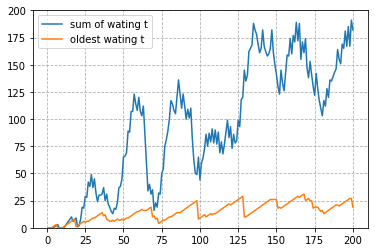

average sum : 148.65
average old : 19.53


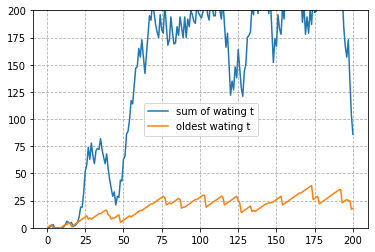

average sum : 178.355
average old : 21.72


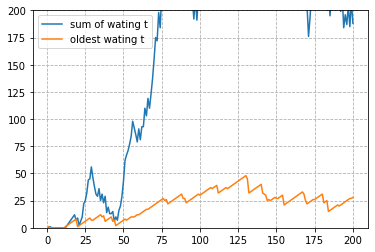

average sum : 88.395
average old : 14.87


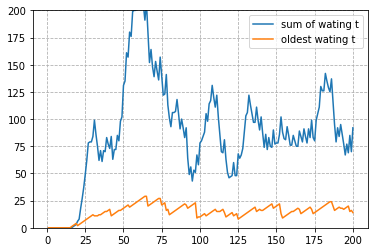

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.21s/it]


In [2]:
import Junction2x2
import Agent
import numpy as np
from tqdm import tqdm
from time import sleep
import matplotlib.pyplot as plt
import torch

train = False
epoch = 10000 if train else 1
agent = [0,0,0,0]
agent[0] = Agent.DQNAgent(state_size=24, action_size=8, train=train, state_dict=torch.load("weight/save.pth"))
agent[1] = Agent.DQNAgent(state_size=24, action_size=8, train=train, state_dict=torch.load("weight/save.pth"))
agent[2] = Agent.DQNAgent(state_size=24, action_size=8, train=train, state_dict=torch.load("weight/save.pth"))
agent[3] = Agent.DQNAgent(state_size=24, action_size=8, train=train, state_dict=torch.load("weight/save.pth"))
reward_info, step_info, longest_wait = [[] for i in range(4)], [], [[] for i in range(4)]
avg_rewards, avg_steps, avg_long_wait = [0, 0, 0, 0], 0, [0, 0, 0, 0]

for i in tqdm(range(epoch)):
    env = Junction2x2.Junction2x2()
    r, l = [0, 0, 0, 0], [0, 0, 0, 0]
    for step in range(200):
        states = list()
        actions = list()
        for j in range(4):
            state = env.J[j].get_state()
            states.append(state)
            action = agent[j].get_action(state)
            actions.append(action)

        j1,j2,j3,j4 = env.step(actions)
        J = [j1,j2,j3,j4]
        if train:
            for j in range(4):
                next_state, reward, done = J[j]
                agent[j].append_sample(states[j], actions[j], reward, next_state, done)
                agent[j].train_model()
                r[j] += reward
                l[j] = max(l[j], env.J[j].get_oldest())

        done_list = [j1[2], j2[2], j3[2], j4[2]]
        if any(done_list):
            break
#         if not train:
#             print(env.render())
#             sleep(0.1)
 

    if not train:
        for j in range(4):
            env.J[j].save_graph(f"performance/performance{j}.png")
            
    if train:
        if i % 500 == 499:
            for j in range(4):
                torch.save(agent[j].model.state_dict(), f"weight/save{i + 1}.pth")
                
        for j in range(4):
            avg_rewards[j] = r[j] if avg_rewards[j] == 0 else avg_rewards[j] * 0.9 + r[j] * 0.1
            avg_long_wait[j] = l[j] if avg_long_wait[j] == 0 else avg_long_wait[j] * 0.9 + l[j] * 0.1
        avg_steps = (step + 1) if avg_steps == 0 else avg_steps * 0.9 + (step + 1) * 0.1

        for j in range(4):
            reward_info[j].append(avg_rewards[j])
            longest_wait[j].append(avg_long_wait[j])
        step_info.append(avg_steps)

        if i % 500 == 499:
            fig = plt.figure()
            for j in range(4):
                plt.subplot(2, 2, j + 1)
                plt.scatter(range(len(reward_info[j])), reward_info[j])

                plt.savefig(f"graph/reward{i + 1}.png")
            plt.clf()

            for j in range(4):
                plt.subplot(2, 2, j + 1)
                plt.scatter(range(len(longest_wait[j])), longest_wait[j])

                plt.savefig(f"graph/longest_wait{i + 1}.png")
            plt.clf()

            plt.scatter(range(len(step_info)), step_info)
            plt.savefig(f"graph/step{i + 1}.png")
            plt.clf()



        


